# 라이브러리

In [106]:
import os
import sys
from glob import glob
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from tqdm.notebook import tqdm
from time import time

import matplotlib.pyplot as plt
import seaborn as sns

## 경로 설정

In [107]:
# train dataset
train_img_dir = '/opt/ml/input/data/train/images'
train_csv_path = '/opt/ml/input/data/train/train.csv'

# eval dataset
eval_img_dir = '/opt/ml/input/data/eval/images'
eval_csv_path = '/opt/ml/input/data/eval/info.csv'

## DataFrame

- 데이터프레임 만들기
    - df_train, df_eval

In [108]:
# check train dataset info
df_train = pd.read_csv(train_csv_path)
print("<< TrainDataset DataFrame >>")
print(df_train.head())

print('\n ======================================================= \n')

# check eval dataset info
print("<< EvaluationDataset DataFrame >>")
df_test = pd.read_csv(eval_csv_path)
print(df_test.head())

<< TrainDataset DataFrame >>
   id  person_id gender  age       mask  label                            path
0   1          0      f   45       mask      4        000001_0_f_45_mask_4.jpg
1   2          0      f   45     normal     16     000002_0_f_45_normal_16.jpg
2   3          0      f   45       mask      4        000003_0_f_45_mask_4.jpg
3   4          0      f   45       mask      4        000004_0_f_45_mask_4.jpg
4   5          0      f   45  incorrect     10  000005_0_f_45_incorrect_10.jpg


<< EvaluationDataset DataFrame >>
                                        ImageID  ans
0  cbc5c6e168e63498590db46022617123f1fe1268.jpg    0
1  0e72482bf56b3581c081f7da2a6180b8792c7089.jpg    0
2  b549040c49190cedc41327748aeb197c1670f14d.jpg    0
3  4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg    0
4  248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg    0


## Image 수

In [109]:
def get_img_len(path):
    img_list = []
    for dir in glob(path + '/*'):
        img_list.extend(glob(dir+'/*'))
    if len(img_list) == 0: # for exception of eval dataseㅋt
        for dir in glob(path + '/*'):
            img_list.extend(glob(dir))
    return len(img_list)

def get_percentage(num_item_list):
    total_ = 0
    for i in num_item_list:
        total_ += i
    ret_list = []
    for i in num_item_list:
        ret_list.append(i / total_ * 100)
    return ret_list

num_train_imgs = get_img_len(train_img_dir)
num_eval_imgs = get_img_len(eval_img_dir)

print('The number of train image: ' + f'{num_train_imgs}')
print('The number of eval image: ' + f'{num_eval_imgs}')
print('percentage of train/eval imgs: ' + f'{get_percentage([num_train_imgs, num_eval_imgs])}')

The number of train image: 18900
The number of eval image: 12600
percentage of train/eval imgs: [60.0, 40.0]


## 요소 중심 분석 - 나이

In [110]:
print(df_train.describe())
# df_train.corr()
# df_train.corr(method='pearson')

                id    person_id           age         label
count  18900.00000  18900.00000  18900.000000  18900.000000
mean    9450.50000   1349.50000     37.708148      5.010317
std     5456.10438    779.44343     16.983208      4.660533
min        1.00000      0.00000     18.000000      0.000000
25%     4725.75000    674.75000     20.000000      1.000000
50%     9450.50000   1349.50000     36.000000      4.000000
75%    14175.25000   2024.25000     55.000000      7.000000
max    18900.00000   2699.00000     60.000000     17.000000


In [111]:
# tabluar dataset(나이) 출력
print(type(tmp))
# print(df_train['age'].value_counts().sort_index()) # int로 출력
# print(df_train['age'].value_counts(bins=age_list, sort=True)) # 범위로 출력

pd.set_option('display.max_row', 500)
pd.set_option('display.max_columns', 100)
print(pd.DataFrame(df_train['age'].value_counts().sort_index()).transpose())

<class 'pandas.core.series.Series'>
       18    19    20   21   22   23   24   25   26   27   28   29   30  31  \
age  1344  2849  1869  287  406  504  434  574  308  105  175  112  119  21   

     32  33  34   35  36  37  38  39   40  41  42   43  44   45  46  47   48  \
age  49  35  91  133  56  21  98  42  140  49  91  126  91  189  98  70  273   

      49   50   51   52   53   54   55   56   57    58   59    60  
age  217  560  441  546  448  574  700  861  742  1113  595  1344  


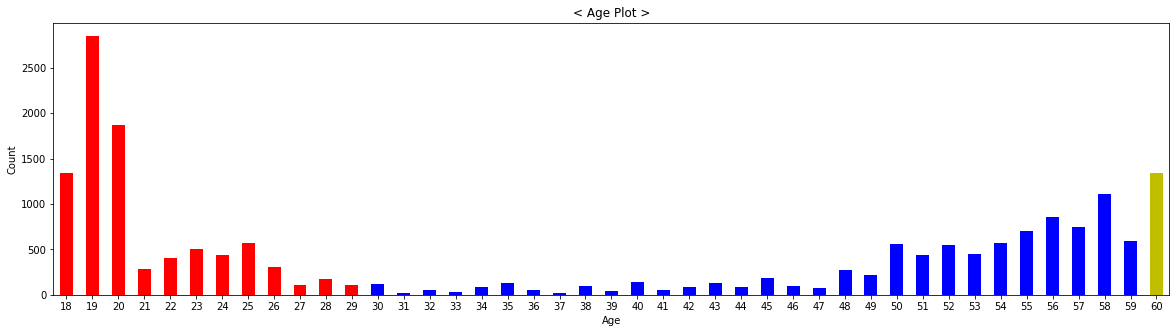

In [112]:
age_list = df_train['age'].unique()
age_list = sorted(age_list)

colors = []
for i in range(18, 61):
    if i < 30:
        colors.append('r')
    elif 30 <= i and i < 60:
        colors.append('b')
    elif 60 <= i:
        colors.append('y')

df = df_train['age'].value_counts().sort_index()
df.plot(kind='bar', rot=0, color=colors)

plt.title("< Age Plot >")
plt.xlabel("Age")
plt.ylabel("Count")

plt.rcParams['figure.figsize'] = [20, 5]
plt.show()

['18<=x<20', '20<=x<30', '30<=x<40', '40<=x<50', '50<=x<55', '55<=x<60', '60<=x<61']
[4193, 4774, 665, 1344, 2569, 4011, 1344]


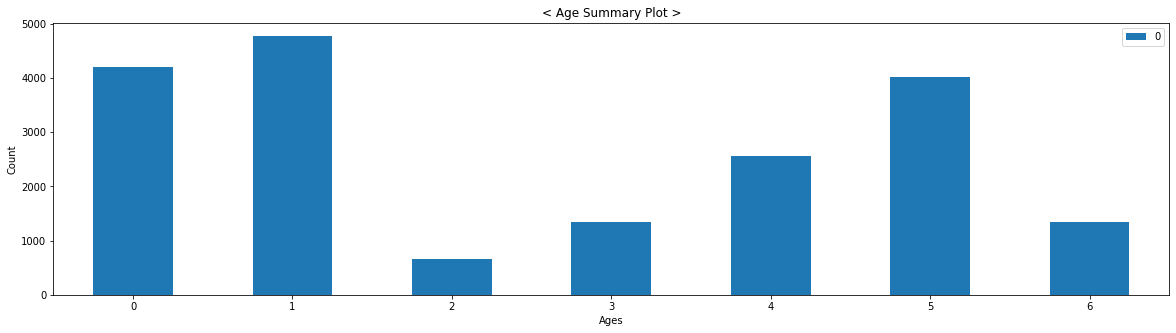

In [123]:
from pandas import Series, DataFrame

# print(age_list)
target = df_train['age'].value_counts().sort_index()
# print(target)

# extra info
plot_labels = []

# to plot
to_plot = []
age_arrange = [20, 30, 40, 50, 55, 60, 61]
bef_ = 18
ind_ = 0
for i in age_arrange:
    tmp_sum = 0
    plot_labels.append(str(bef_) + '<=x<' + str(i))
    for k in range(bef_, i):
        tmp_sum += target[k]
    to_plot.append(tmp_sum)
    bef_ = i
    ind_ += 1

print(plot_labels)
print(to_plot)
    
df = DataFrame(to_plot)
df.plot(kind='bar', rot=0)

plt.title("< Age Summary Plot >")
plt.xlabel("Ages")
plt.ylabel("Count")

plt.show()
    
    

# 레이블 별 분포

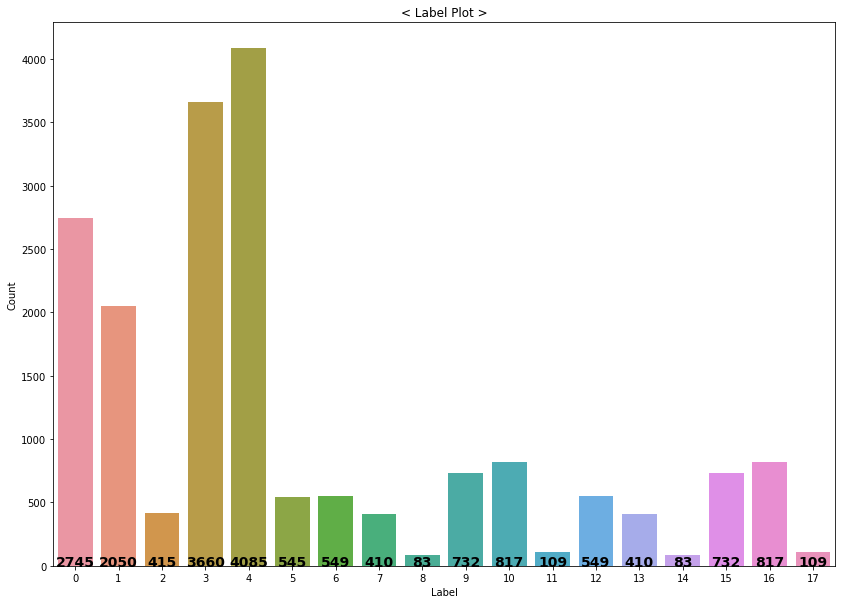

In [114]:
# label_list = df_train['label'].unique()
# label_list = sorted(label_list)

# print(df_train['label'].value_counts().sort_index()) # int로 출력

plt.figure(figsize=(14, 10)) 
ax = sns.countplot(x = 'label', data = df_train)

# df = df_train['label'].value_counts().sort_index()
# df.plot(kind='bar', rot=0, color=colors)

plt.title("< Label Plot >")
plt.xlabel("Label")
plt.ylabel("Count")

for i, v in enumerate(df_train['label'].value_counts().sort_index()):
    ax.text(i, 0, v, horizontalalignment = 'center', size = 14, color = 'black', fontweight = 'bold')

# plt.rcParams['figure.figsize'] = [20, 5]
plt.show()

# 성별 별 분포

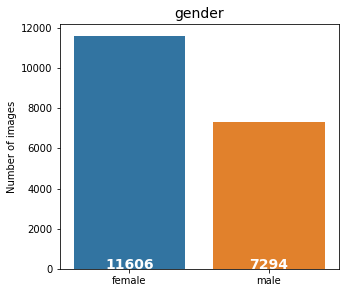

In [115]:
plt.figure(figsize=(5, 4.5)) 
ax = sns.countplot(x = 'gender', data = df_train)

plt.xticks( np.arange(2), ['female', 'male'] )
plt.title('gender',fontsize= 14)
plt.xlabel('')
plt.ylabel('Number of images')

for i, v in enumerate(df_train['gender'].value_counts().sort_index()):
    ax.text(i, 0, v, horizontalalignment = 'center', size = 14, color = 'w', fontweight = 'bold')
    
plt.show()

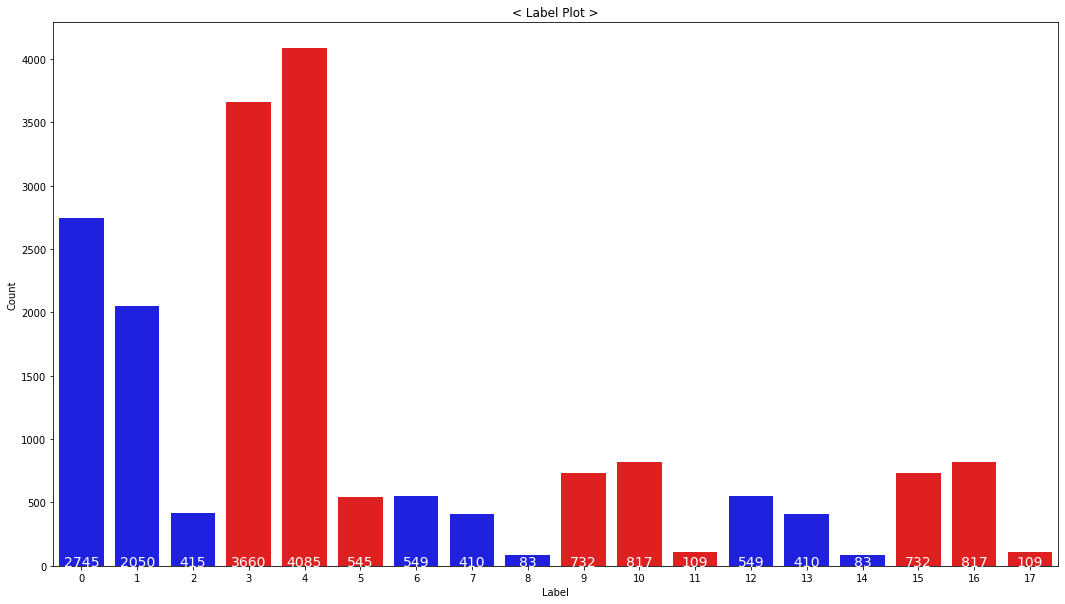

In [116]:
# label_list = df_train['label'].unique()
# label_list = sorted(label_list)

# print(df_train['label'].value_counts().sort_index()) # int로 출력

colors = ['b','b','b','r','r','r','b','b','b','r','r','r','b','b','b','r','r','r']

plt.figure(figsize=(18, 10)) 
ax = sns.countplot(x = 'label', data = df_train, palette=colors)

# df = df_train['label'].value_counts().sort_index()
# df.plot(kind='bar', rot=0, color=colors)

plt.title("< Label Plot >")
plt.xlabel("Label")
plt.ylabel("Count")

for i, v in enumerate(df_train['label'].value_counts().sort_index()):
    ax.text(i, 0, v, horizontalalignment = 'center', size = 14, color = 'w')

# plt.rcParams['figure.figsize'] = [20, 5]
plt.show()